In [1]:
BATCH_SIZE = 768
IMAGE_COUNT = 1790594
IMAGE_SIZE = 256

In [2]:
import os
os.sys.path.append('../input/rsna-sped-ds-utility/')
import glob
import math
import numpy as np 
import pandas as pd 
import tensorflow as tf
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import efficientnet.tfkeras as efn 

from kaggle_datasets import KaggleDatasets
from sklearn.model_selection import KFold

In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [4]:
GCS_DS_PATH_TRAIN = KaggleDatasets().get_gcs_path('rsna-pe-tfrecords-v2')
GCS_DS_PATH_TRAIN

'gs://kds-b79246e245e6e9677a4e300c1495dfd7ae79b471e545e4c3fa045344'

In [5]:
UNLABELED_TFRECORD_FORMAT = {'SpecificCharacterSet': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'ImageType': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'SOPClassUID': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'SOPInstanceUID': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'Modality': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'SliceThickness': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'KVP': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'GantryDetectorTilt': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'TableHeight': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'RotationDirection': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'XRayTubeCurrent': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'Exposure': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'ConvolutionKernel': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'PatientPosition': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'StudyInstanceUID': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'SeriesInstanceUID': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'SeriesNumber': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'InstanceNumber': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'ImagePositionPatient': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'ImageOrientationPatient': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'FrameOfReferenceUID': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'SamplesPerPixel': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'PhotometricInterpretation': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'Rows': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'Columns': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'PixelSpacing': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'BitsAllocated': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'BitsStored': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'HighBit': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'PixelRepresentation': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'WindowCenter': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'WindowWidth': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'RescaleIntercept': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'RescaleSlope': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'image': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None)}

In [6]:
LABELED_TFRECORD_FORMAT = {'SpecificCharacterSet': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'ImageType': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'SOPClassUID': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'SOPInstanceUID': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'Modality': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'SliceThickness': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'KVP': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'GantryDetectorTilt': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'TableHeight': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'RotationDirection': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'XRayTubeCurrent': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'Exposure': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'ConvolutionKernel': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'PatientPosition': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'StudyInstanceUID': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'SeriesInstanceUID': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'SeriesNumber': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'InstanceNumber': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'ImagePositionPatient': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'ImageOrientationPatient': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'FrameOfReferenceUID': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'SamplesPerPixel': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'PhotometricInterpretation': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'Rows': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'Columns': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'PixelSpacing': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'BitsAllocated': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'BitsStored': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'HighBit': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'PixelRepresentation': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'WindowCenter': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'WindowWidth': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'RescaleIntercept': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'RescaleSlope': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'negative_exam_for_pe': tf.io.FixedLenFeature(shape=(), dtype=tf.int64, default_value=None),
 'qa_motion': tf.io.FixedLenFeature(shape=(), dtype=tf.int64, default_value=None),
 'qa_contrast': tf.io.FixedLenFeature(shape=(), dtype=tf.int64, default_value=None),
 'flow_artifact': tf.io.FixedLenFeature(shape=(), dtype=tf.int64, default_value=None),
 'rv_lv_ratio_gte_1': tf.io.FixedLenFeature(shape=(), dtype=tf.int64, default_value=None),
 'rv_lv_ratio_lt_1': tf.io.FixedLenFeature(shape=(), dtype=tf.int64, default_value=None),
 'leftsided_pe': tf.io.FixedLenFeature(shape=(), dtype=tf.int64, default_value=None),
 'chronic_pe': tf.io.FixedLenFeature(shape=(), dtype=tf.int64, default_value=None),
 'true_filling_defect_not_pe': tf.io.FixedLenFeature(shape=(), dtype=tf.int64, default_value=None),
 'rightsided_pe': tf.io.FixedLenFeature(shape=(), dtype=tf.int64, default_value=None),
 'acute_and_chronic_pe': tf.io.FixedLenFeature(shape=(), dtype=tf.int64, default_value=None),
 'central_pe': tf.io.FixedLenFeature(shape=(), dtype=tf.int64, default_value=None),
 'indeterminate': tf.io.FixedLenFeature(shape=(), dtype=tf.int64, default_value=None),
 'pe_present_on_image': tf.io.FixedLenFeature(shape=(), dtype=tf.int64, default_value=None),
 'image': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None)}

In [7]:
fs = glob.glob('../input/rsna-pe-tfrecords-v2/train/*.tfrec')
fs = [GCS_DS_PATH_TRAIN + '/train/' + os.path.basename(f) for f in fs]
fs = np.array(fs)

kf = KFold(n_splits=5, random_state=23, shuffle=True)
for fold, (train_index, valid_index) in enumerate(kf.split(fs)):
    if fold == 1:
        break

In [8]:
def read_tfrecord(example, record_format):
    try:
        example = tf.io.parse_single_example(example, record_format)
    except:
        print (example)
        raise
    
    data = {k:tf.cast(example[k], record_format[k].dtype) for k in example}
        
    return data

def read_labeled_tfrecord(example):
    return read_tfrecord(example, LABELED_TFRECORD_FORMAT)

def read_unlabeled_tfrecord(example):
    return read_tfrecord(example, UNLABELED_TFRECORD_FORMAT)

In [9]:
# https://www.kaggle.com/cdeotte/rotation-augmentation-gpu-tpu-0-96
def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear = math.pi * shear / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape( tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3] )
        
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape( tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3] )    
    
    # ZOOM MATRIX
    zoom_matrix = tf.reshape( tf.concat([one/height_zoom,zero,zero, zero,one/width_zoom,zero, zero,zero,one],axis=0),[3,3] )
    
    # SHIFT MATRIX
    shift_matrix = tf.reshape( tf.concat([one,zero,height_shift, zero,one,width_shift, zero,zero,one],axis=0),[3,3] )
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), K.dot(zoom_matrix, shift_matrix))

def transform(image, label):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    DIM = IMAGE_SIZE
    XDIM = DIM%2 #fix for size 331
    
    rot = 10. * tf.random.normal([1],dtype='float32')
    shr = 3. * tf.random.normal([1],dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1],dtype='float32') / 20.
    w_zoom = 1.0 + tf.random.normal([1],dtype='float32') / 20.
    h_shift = 16. * tf.random.normal([1],dtype='float32') 
    w_shift = 16. * tf.random.normal([1],dtype='float32') 
  
    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image,tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3]), label

In [10]:
def window(img, WL, WW):
    upper, lower = WL+WW//2, WL-WW//2
#     X = img
    X = tf.clip_by_value(img, lower, upper)
    X = X - tf.keras.backend.min(X)
    X = X / tf.keras.backend.max(X)
    return X
    
def prepare_for_train(data):
#     image = tf.reshape(data["image"], [512, 512])
#     image = tf.io.decode_raw(data["image"], tf.int16) / 32767
    image = tf.io.decode_raw(data["image"], tf.int16)
    image = tf.cast(image, tf.float32)
    image = tf.reshape(image, [512, 512, 1])
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    
    label = data["pe_present_on_image"]
    leftsided_pe = data["leftsided_pe"]
    rightsided_pe = data["rightsided_pe"]
    mask_width = 90
    m1 = tf.zeros((IMAGE_SIZE, mask_width, 1))
    m2 = tf.ones((IMAGE_SIZE, IMAGE_SIZE - mask_width, 1))
    left_mask = tf.concat([m2, m1], axis=1)
    right_mask = tf.concat([m1, m2], axis=1)

    # mask half of the image
    mask_rate = 0.5
    
    r = tf.random.uniform([], minval=0, maxval=1)
    image = tf.cond(leftsided_pe == 0 and r < mask_rate, lambda: image * left_mask, lambda: image)
    
    r = tf.random.uniform([], minval=0, maxval=1)
    image = tf.cond(rightsided_pe == 0 and r < mask_rate, lambda: image * right_mask, lambda: image)
    
    
    M = tf.strings.to_number(data['RescaleSlope'])
    B = tf.strings.to_number(data['RescaleIntercept'])
    image = image * M + B
    i1 = window(image, -600, 1500)
    i2 = window(image, 100, 700)
    i3 = window(image, 40, 400)
    image = tf.concat([i1, i2, i3], axis=2)
    
    return image, label

In [11]:
AUTO = tf.data.experimental.AUTOTUNE
def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

In [12]:
train_dataset = load_dataset(fs[train_index], labeled=True)
train_dataset = train_dataset.map(prepare_for_train, num_parallel_calls=AUTO)
train_dataset = train_dataset.map(transform, num_parallel_calls=AUTO)
train_dataset = train_dataset.prefetch(AUTO)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(BATCH_SIZE)


valid_dataset = load_dataset(fs[valid_index], labeled=True)
valid_dataset = valid_dataset.map(prepare_for_train, num_parallel_calls=AUTO)
valid_dataset = valid_dataset.prefetch(AUTO)
valid_dataset = valid_dataset.batch(BATCH_SIZE)

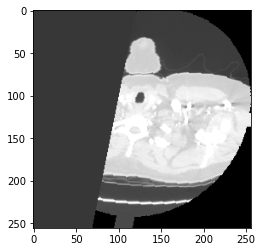

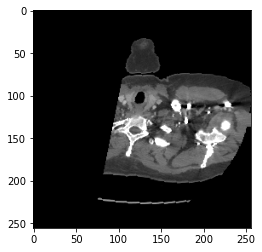

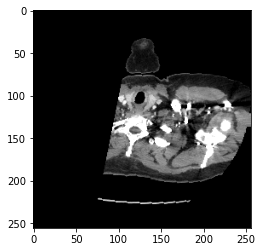

In [13]:
for index, (image, label) in enumerate(train_dataset.as_numpy_iterator()):
    plt.imshow(image[0][:,:,0], cmap='gray')
    plt.show()
    plt.imshow(image[0][:,:,1], cmap='gray')
    plt.show()
    plt.imshow(image[0][:,:,2], cmap='gray')
    plt.show()
#     print(label)
    break

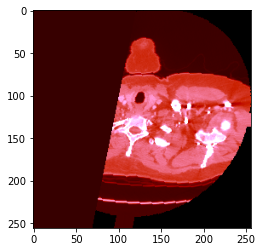

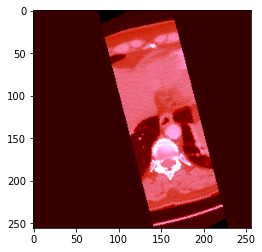

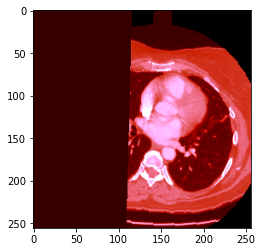

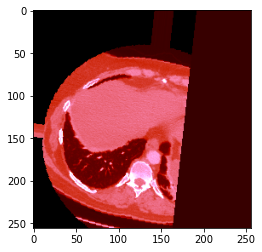

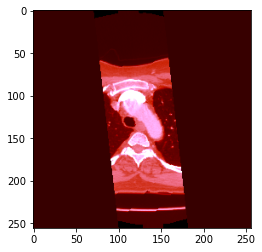

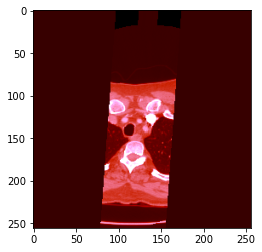

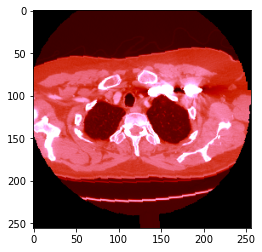

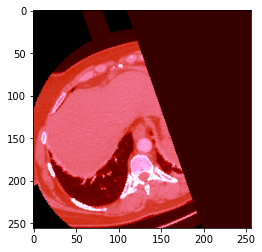

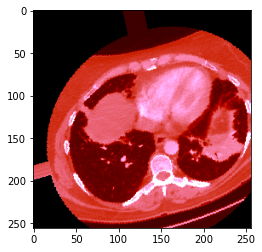

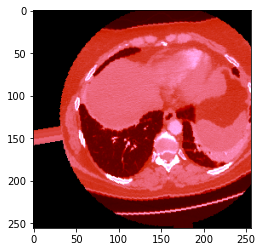

In [14]:
for i in range(10):
    plt.imshow(image[i])
    plt.show()

In [15]:
from tensorflow.keras import models

In [16]:
def create_model():
    x_input = tf.keras.layers.Input(shape=(None, None, 3))
#     x = x_input
#     mt = efn.EfficientNetB1()
#     mt.save_weights('t.h5')
#     mt = efn.EfficientNetB1(
#         input_tensor=x,
#         include_top=False,
#         weights=None,
#     )
#     mt.load_weights('t.h5', by_name=True, skip_mismatch=True)
#     x = tf.keras.layers.GlobalMaxPool2D()(mt.layers[-1].output)
#     y = tf.keras.layers.Dense(1, activation='sigmoid')(x)
#     model = tf.keras.models.Model(x_input, y)
    model = models.load_model('../input/efficientnet-b1-rsna/efb1_fold1_1006.h5')
    optimizer = tf.keras.optimizers.Adam(lr=1e-5)
    loss = tf.keras.losses.BinaryCrossentropy()
    model.compile(optimizer, loss)
    return model 

with strategy.scope():
    model = create_model()

In [17]:
class ValidCB(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        model.save('efb1_{:03d}.h5'.format(epoch))
        print('')
        
model.fit(train_dataset,
          validation_data=valid_dataset,
          steps_per_epoch=int(IMAGE_COUNT * 0.8 // BATCH_SIZE),
#           steps_per_epoch=10,
          epochs=9,
          verbose=1,
          callbacks=[ValidCB()],
         )

Epoch 1/9
1865/1865 [==============================] - 1030s 552ms/step - loss: 0.0813 - val_loss: 0.0943
Epoch 2/9
1865/1865 [==============================] - 1023s 548ms/step - loss: 0.0780 - val_loss: 0.0926
Epoch 3/9
1865/1865 [==============================] - 983s 527ms/step - loss: 0.0764 - val_loss: 0.0919
Epoch 4/9
1865/1865 [==============================] - 995s 533ms/step - loss: 0.0756 - val_loss: 0.0915
Epoch 5/9
1865/1865 [==============================] - 996s 534ms/step - loss: 0.0746 - val_loss: 0.0910
Epoch 6/9
1865/1865 [==============================] - 1006s 540ms/step - loss: 0.0739 - val_loss: 0.0914
Epoch 7/9
1865/1865 [==============================] - 1059s 568ms/step - loss: 0.0732 - val_loss: 0.0912
Epoch 8/9
1865/1865 [==============================] - 1019s 546ms/step - loss: 0.0729 - val_loss: 0.0919
Epoch 9/9
1865/1865 [==============================] - 1039s 557ms/step - loss: 0.0722 - val_loss: 0.0919
